In [2]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


# Setting seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
%matplotlib inline

In [3]:
train_1= pd.read_csv("/content/drive/MyDrive/Capstone/CMAPSSData/train_FD001.txt" ,sep=" ",header=None)
train_1.drop(columns=[26,27],inplace=True)

In [4]:
test_1= pd.read_csv("/content/drive/MyDrive/Capstone/CMAPSSData/test_FD001.txt",sep=" ",header=None)
test_1.drop(columns=[26,27],inplace=True)

In [5]:
rul_1= pd.read_csv("/content/drive/MyDrive/Capstone/CMAPSSData/RUL_FD001.txt",sep=" ",header=None)
rul_1.drop(columns=[1],inplace=True)

In [6]:
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
train_1.columns = columns

In [7]:
test_1.columns = columns

In [8]:
description = train_1.describe()
description.loc['std']

unit_number       2.922763e+01
time_in_cycles    6.888099e+01
setting_1         2.187313e-03
setting_2         2.930621e-04
TRA               0.000000e+00
T2                6.537152e-11
T24               5.000533e-01
T30               6.131150e+00
T50               9.000605e+00
P2                3.394700e-12
P15               1.388985e-03
P30               8.850923e-01
Nf                7.098548e-02
Nc                2.208288e+01
epr               4.660829e-13
Ps30              2.670874e-01
phi               7.375534e-01
NRf               7.191892e-02
NRc               1.907618e+01
BPR               3.750504e-02
farB              1.556432e-14
htBleed           1.548763e+00
Nf_dmd            0.000000e+00
PCNfR_dmd         0.000000e+00
W31               1.807464e-01
W32               1.082509e-01
Name: std, dtype: float64

In [9]:
#delete columns with constant values that do not carry information about the state of the unit
train_1.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

In [10]:
#Adding RUL column 
#function for preparing training data and forming a RUL column with information about the remaining
# before breaking cycles
def prepare_train_data(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['unit_number','max']
    df = df.merge(fd_RUL, on=['unit_number'], how='left')
    df['RUL'] = df['max'] - df['time_in_cycles']
    df.drop(columns=['max'],inplace = True)
    return df[df['time_in_cycles'] > factor]

In [11]:
train_1 = prepare_train_data(train_1)

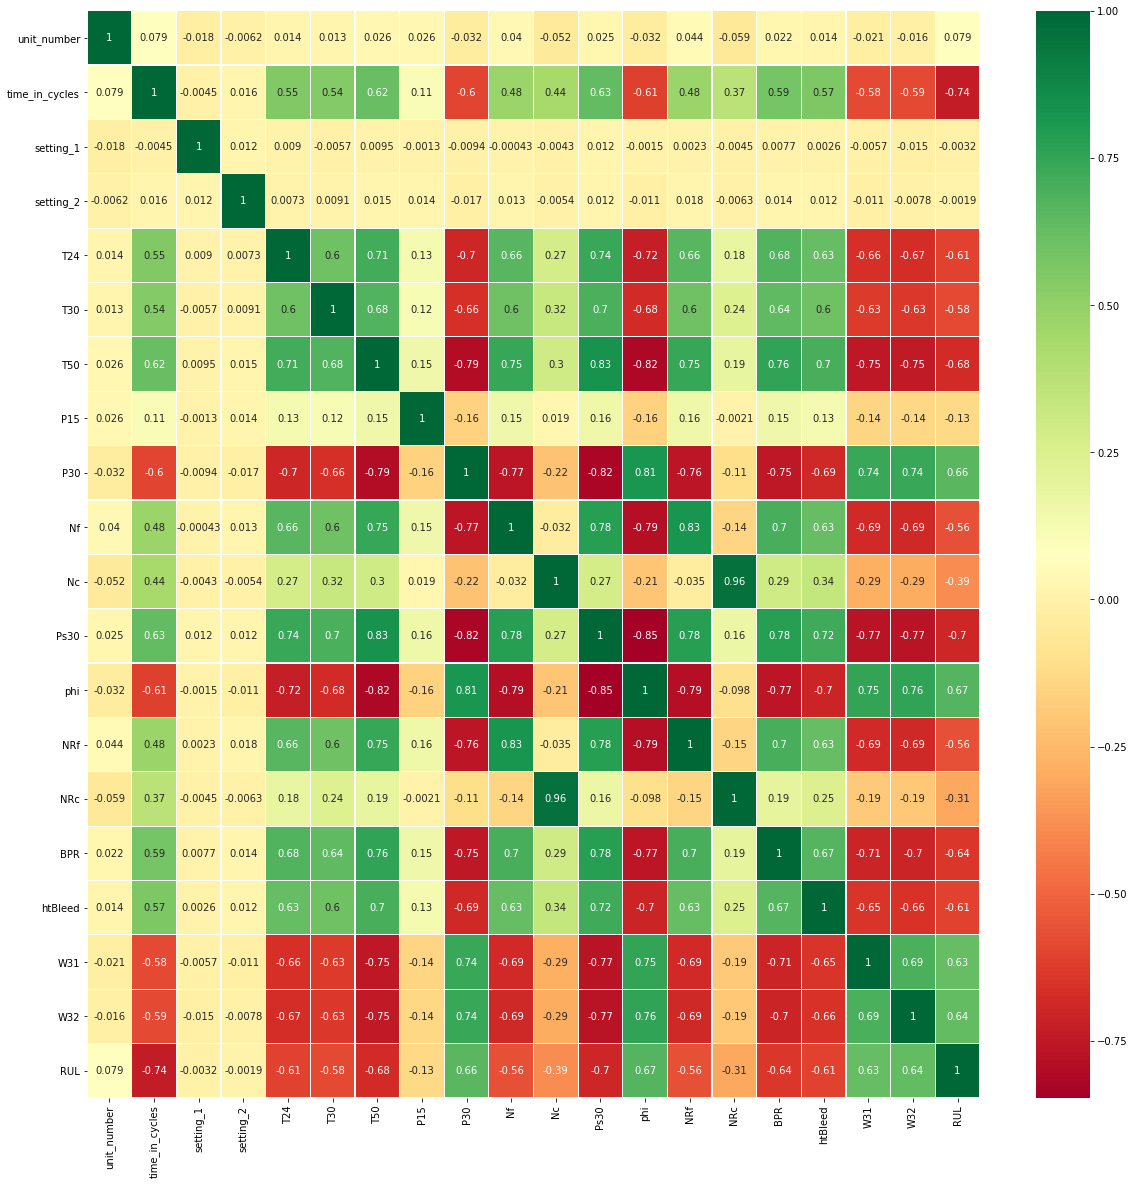

In [12]:
sns.heatmap(train_1.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

In [13]:
# generate label columns for training data
w1 = 30
w0 = 15
train_1['label1'] = np.where(train_1['RUL'] <= w1, 1, 0 )
train_1['label2'] = train_1['label1']
train_1.loc[train_1['RUL'] <= w0, 'label2'] = 2
train_1.head()

,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL,label1,label2
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187,0,0


In [14]:
# MinMax normalization
train_1['cycle_norm'] = train_1['time_in_cycles']
cols_normalize = train_1.columns.difference(['unit_number','time_in_cycles','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_1 = pd.DataFrame(min_max_scaler.fit_transform(train_1[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_1.index)
join_1 = train_1[train_1.columns.difference(cols_normalize)].join(norm_train_1)
train_1 = join_1.reindex(columns = train_1.columns)
train_1.head()

,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,1.0,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,1.0,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,1.0,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187,0,0,0.01108


In [15]:
test_1['cycle_norm'] = test_1['time_in_cycles']
norm_test_1 = pd.DataFrame(min_max_scaler.transform(test_1[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_1.index)
test_join_1 = test_1[test_1.columns.difference(cols_normalize)].join(norm_test_1)
test_1 = test_join_1.reindex(columns = test_1.columns)
test_1 = test_1.reset_index(drop=True)
test_1.head()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,cycle_norm
0,1,1,0.632184,0.750000,100.0,518.67,0.545181,0.310661,0.269413,14.62,1.0,0.652174,0.212121,0.127614,1.3,0.208333,0.646055,0.220588,0.132160,0.308965,0.03,0.333333,2388,100.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,100.0,518.67,0.150602,0.379551,0.222316,14.62,1.0,0.805153,0.166667,0.146684,1.3,0.386905,0.739872,0.264706,0.204768,0.213159,0.03,0.416667,2388,100.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,100.0,518.67,0.376506,0.346632,0.322248,14.62,1.0,0.685990,0.227273,0.158081,1.3,0.386905,0.699360,0.220588,0.155640,0.458638,0.03,0.416667,2388,100.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,100.0,518.67,0.370482,0.285154,0.408001,14.62,1.0,0.679549,0.196970,0.105717,1.3,0.255952,0.573561,0.250000,0.170090,0.257022,0.03,0.250000,2388,100.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,100.0,518.67,0.391566,0.352082,0.332039,14.62,1.0,0.694042,0.166667,0.102396,1.3,0.273810,0.737740,0.220588,0.152751,0.300885,0.03,0.166667,2388,100.0,0.658915,0.716377,0.01108


In [16]:
# generate column max for test data
rul = pd.DataFrame(test_1.groupby('unit_number')['time_in_cycles'].max()).reset_index()
rul.columns = ['unit_number', 'max']
rul_1.columns = ['more']
rul_1['unit_number'] = rul_1.index + 1
rul_1['max'] = rul['max'] + rul_1['more']
rul_1.drop('more', axis=1, inplace=True)

In [17]:
# generate RUL for test data
test_1 = test_1.merge(rul_1, on=['unit_number'], how='left')
test_1['RUL'] = test_1['max'] - test_1['time_in_cycles']
test_1.drop('max', axis=1, inplace=True)
test_1.head()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,cycle_norm,RUL
0,1,1,0.632184,0.750000,100.0,518.67,0.545181,0.310661,0.269413,14.62,1.0,0.652174,0.212121,0.127614,1.3,0.208333,0.646055,0.220588,0.132160,0.308965,0.03,0.333333,2388,100.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,100.0,518.67,0.150602,0.379551,0.222316,14.62,1.0,0.805153,0.166667,0.146684,1.3,0.386905,0.739872,0.264706,0.204768,0.213159,0.03,0.416667,2388,100.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,100.0,518.67,0.376506,0.346632,0.322248,14.62,1.0,0.685990,0.227273,0.158081,1.3,0.386905,0.699360,0.220588,0.155640,0.458638,0.03,0.416667,2388,100.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,100.0,518.67,0.370482,0.285154,0.408001,14.62,1.0,0.679549,0.196970,0.105717,1.3,0.255952,0.573561,0.250000,0.170090,0.257022,0.03,0.250000,2388,100.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,100.0,518.67,0.391566,0.352082,0.332039,14.62,1.0,0.694042,0.166667,0.102396,1.3,0.273810,0.737740,0.220588,0.152751,0.300885,0.03,0.166667,2388,100.0,0.658915,0.716377,0.01108,138


In [18]:
# generate label columns w0 and w1 for test data
test_1['label1'] = np.where(test_1['RUL'] <= w1, 1, 0 )
test_1['label2'] = test_1['label1']
test_1.loc[test_1['RUL'] <= w0, 'label2'] = 2
test_1.head()

,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,P15,P30,Nf,Nc,epr,Ps30,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,100.0,518.67,0.545181,0.310661,0.269413,14.62,1.0,0.652174,0.212121,0.127614,1.3,0.208333,0.646055,0.220588,0.132160,0.308965,0.03,0.333333,2388,100.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,100.0,518.67,0.150602,0.379551,0.222316,14.62,1.0,0.805153,0.166667,0.146684,1.3,0.386905,0.739872,0.264706,0.204768,0.213159,0.03,0.416667,2388,100.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,100.0,518.67,0.376506,0.346632,0.322248,14.62,1.0,0.685990,0.227273,0.158081,1.3,0.386905,0.699360,0.220588,0.155640,0.458638,0.03,0.416667,2388,100.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,100.0,518.67,0.370482,0.285154,0.408001,14.62,1.0,0.679549,0.196970,0.105717,1.3,0.255952,0.573561,0.250000,0.170090,0.257022,0.03,0.250000,2388,100.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,100.0,518.67,0.391566,0.352082,0.332039,14.62,1.0,0.694042,0.166667,0.102396,1.3,0.273810,0.737740,0.220588,0.152751,0.300885,0.03,0.166667,2388,100.0,0.658915,0.716377,0.01108,138,0,0


In [19]:
# pick a large window size of 50 cycles
sequence_length = 50

In [20]:
# preparing data for visualizations 
# window of 50 cycles prior to a failure point for engine id 3
engine_id3 = test_1[test_1['unit_number'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['T2','T24','T30','T50','P2','P15','P30','Nf','Nc','epr']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

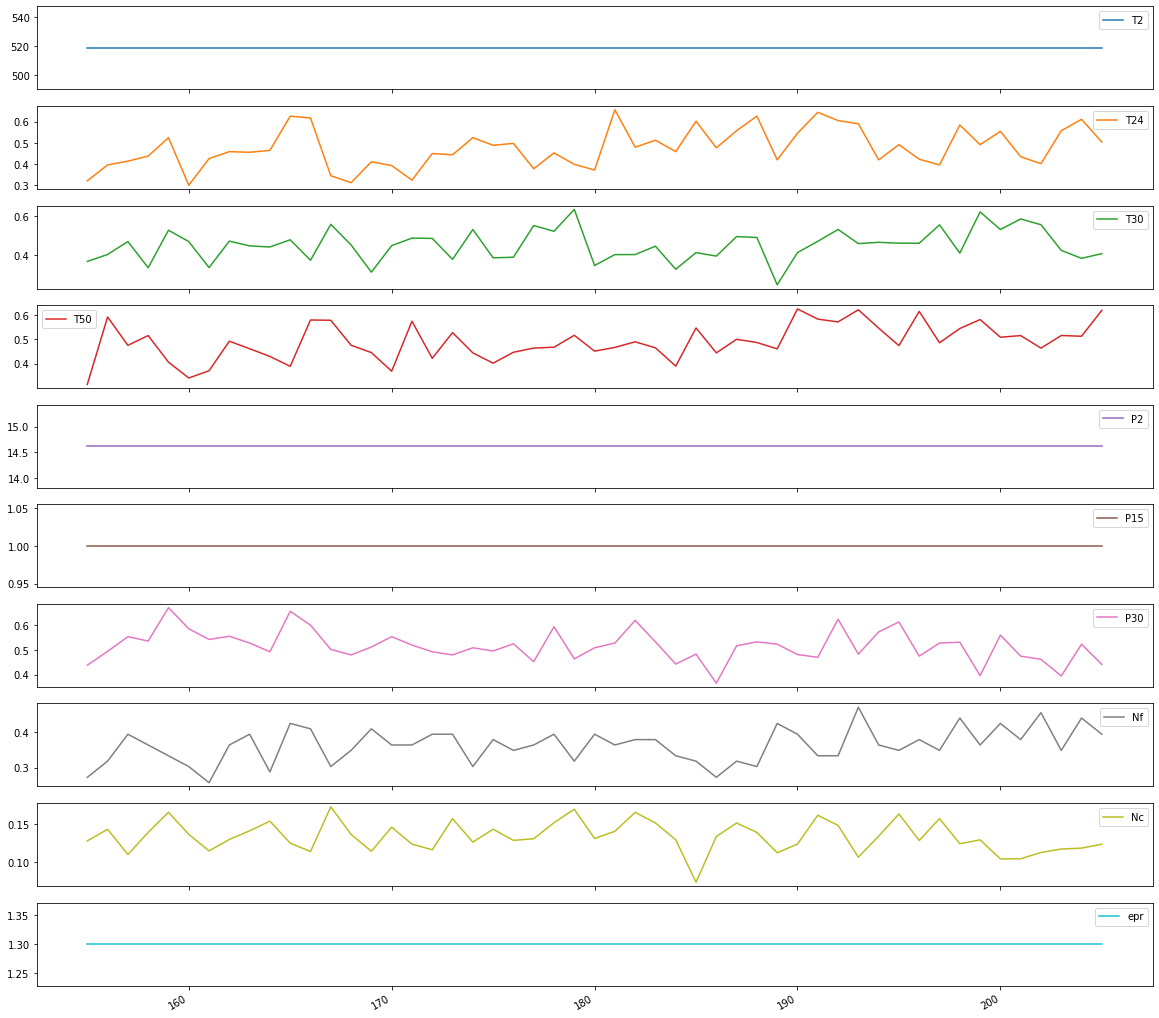

In [21]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

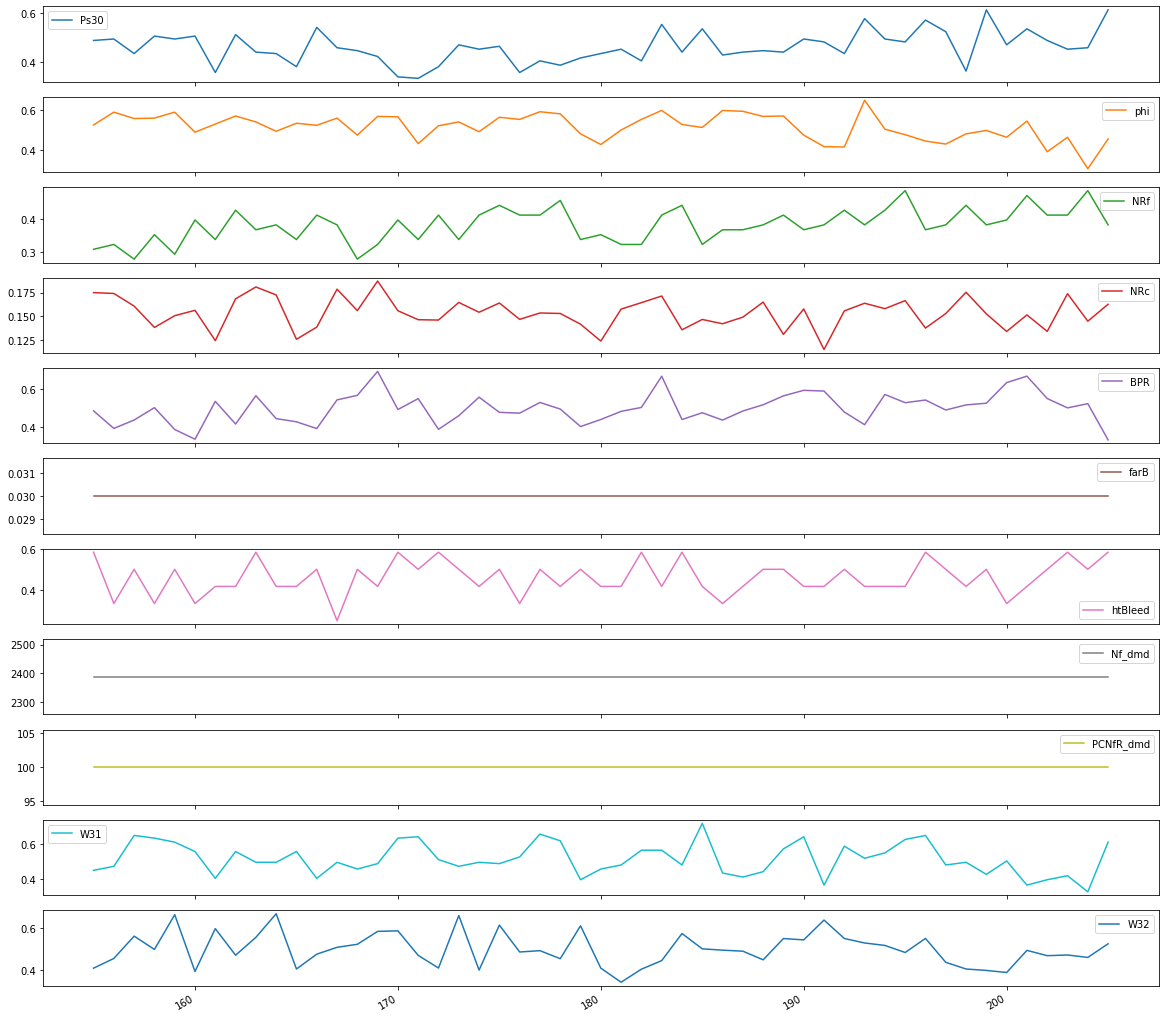

In [22]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 11-21 
ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

In [24]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [25]:
sequence_cols = ['setting_1', 'setting_2', 'cycle_norm','T24','T30','T50','P15','P30','Nf','Nc','Ps30','phi','NRf','NRc','BPR','htBleed','W31','W32']

In [26]:
train_1

,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191,0,0,0.000000
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190,0,0,0.002770
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,1.0,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189,0,0,0.005540
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,1.0,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188,0,0,0.008310
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,1.0,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187,0,0,0.011080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,0.477011,0.250000,0.686747,0.587312,0.782917,1.0,0.254428,0.439394,0.196491,0.726190,0.170576,0.558824,0.194344,0.656791,0.750000,0.271318,0.109500,4,1,2,0.540166
20627,100,197,0.408046,0.083333,0.701807,0.729453,0.866475,1.0,0.162641,0.500000,0.194651,0.708333,0.211087,0.500000,0.188668,0.727203,0.583333,0.124031,0.366197,3,1,2,0.542936
20628,100,198,0.522989,0.500000,0.665663,0.684979,0.775321,1.0,0.175523,0.515152,0.198196,0.738095,0.281450,0.529412,0.212148,0.922278,0.833333,0.232558,0.053991,2,1,2,0.545706
20629,100,199,0.436782,0.750000,0.608434,0.746021,0.747468,1.0,0.133655,0.530303,0.233285,0.916667,0.208955,0.514706,0.203065,0.823394,0.583333,0.116279,0.234466,1,1,2,0.548476


In [29]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_1[train_1['unit_number']==id], sequence_length, sequence_cols)) 
           for id in train_1['unit_number'].unique())


In [30]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 18)

In [31]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [32]:
# generate labels
label_gen = [gen_labels(train_1[train_1['unit_number']==id], sequence_length, ['label1']) 
             for id in train_1['unit_number'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

LSTM

In [88]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

lstm_model = Sequential()

lstm_model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=300,
         return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(
          units=150,
          return_sequences=False))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(units=nb_out, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [89]:
print(lstm_model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 300)           382800    
_________________________________________________________________
dropout_13 (Dropout)         (None, 50, 300)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 150)               270600    
_________________________________________________________________
dropout_14 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 151       
Total params: 653,551
Trainable params: 653,551
Non-trainable params: 0
_________________________________________________________________
None


In [91]:
%%time
# fit the network
lstm_model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/10
75/75 [==============================] - 79s 1s/step - loss: 0.1905 - accuracy: 0.9211 - val_loss: 0.1520 - val_accuracy: 0.9348
Epoch 2/10
75/75 [==============================] - 78s 1s/step - loss: 0.1044 - accuracy: 0.9576 - val_loss: 0.1444 - val_accuracy: 0.9450
Epoch 3/10
75/75 [==============================] - 78s 1s/step - loss: 0.0791 - accuracy: 0.9679 - val_loss: 0.0463 - val_accuracy: 0.9898
Epoch 4/10
75/75 [==============================] - 78s 1s/step - loss: 0.0694 - accuracy: 0.9710 - val_loss: 0.0619 - val_accuracy: 0.9757
Epoch 5/10
75/75 [==============================] - 78s 1s/step - loss: 0.0772 - accuracy: 0.9676 - val_loss: 0.0656 - val_accuracy: 0.9629
Epoch 6/10
75/75 [==============================] - 77s 1s/step - loss: 0.0599 - accuracy: 0.9739 - val_loss: 0.0496 - val_accuracy: 0.9757
Epoch 7/10
75/75 [==============================] - 76s 1s/step - loss: 0.0571 - accuracy: 0.9745 - val_loss: 0.0517 - val_accuracy: 0.9757
Epoch 8/10
75/75 [==

In [92]:
# training metrics
scores = lstm_model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 28s 351ms/step - loss: 0.0445 - accuracy: 0.9826
Accurracy: 0.9825986623764038


79/79 [==============================] - 28s 351ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


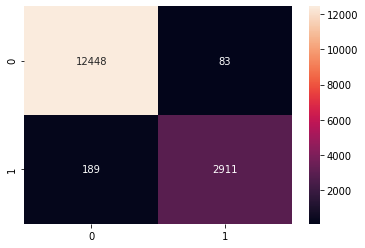

In [106]:
# make predictions and compute confusion matrix
y_pred = lstm_model.predict_classes(seq_array,verbose=1, batch_size=200)
y_true = label_array
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [96]:
# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

precision =  0.9722778891115564 
 recall =  0.9390322580645162


In [97]:
seq_array_test_last = [test_1[test_1['unit_number']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_1['unit_number'].unique() if len(test_1[test_1['unit_number']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 18)

In [98]:
y_mask = [len(test_1[test_1['unit_number']==id]) >= sequence_length for id in test_1['unit_number'].unique()]

In [99]:
label_array_test_last = test_1.groupby('unit_number')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [100]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 18)
(93, 1)


In [101]:
# test metrics
scores_test = lstm_model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.0503 - accuracy: 0.9892
Accurracy: 0.9892473220825195


Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


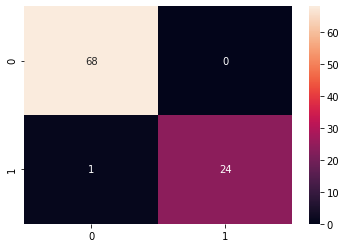

In [107]:
# make predictions and compute confusion matrix
y_pred_test = lstm_model.predict_classes(seq_array_test_last)
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d')

In [103]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  1.0 
 Recall:  0.96 
 F1-score: 0.9795918367346939


In [105]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM'])
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.989247,1.0,0.96,0.979592


#MLP


In [65]:
# mlp for binary classification
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [67]:
# define model
mlp_model = Sequential()
mlp_model.add(Dense(48, activation='relu', kernel_initializer='he_normal', input_shape=(nb_features * 50,)))
mlp_model.add(Dense(24, activation='relu', kernel_initializer='he_normal'))
mlp_model.add(Dense(12, activation='relu', kernel_initializer='he_normal'))
mlp_model.add(Dense(1, activation='sigmoid'))
print(mlp_model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 48)                43248     
_________________________________________________________________
dense_13 (Dense)             (None, 24)                1176      
_________________________________________________________________
dense_14 (Dense)             (None, 12)                300       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 13        
Total params: 44,737
Trainable params: 44,737
Non-trainable params: 0
_________________________________________________________________
None


In [68]:
# compile the model
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
# fit the model
mlp_model.fit(seq_array.reshape(15631, 900), label_array, epochs=150, batch_size=200, validation_split=0.2, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=0, mode='auto')])

Epoch 1/150
63/63 [==============================] - 1s 8ms/step - loss: 0.4209 - accuracy: 0.7956 - val_loss: 0.2189 - val_accuracy: 0.9015
Epoch 2/150
63/63 [==============================] - 0s 4ms/step - loss: 0.1694 - accuracy: 0.9272 - val_loss: 0.1870 - val_accuracy: 0.9191
Epoch 3/150
63/63 [==============================] - 0s 4ms/step - loss: 0.1516 - accuracy: 0.9361 - val_loss: 0.1571 - val_accuracy: 0.9300
Epoch 4/150
63/63 [==============================] - 0s 5ms/step - loss: 0.1140 - accuracy: 0.9512 - val_loss: 0.1153 - val_accuracy: 0.9485
Epoch 5/150
63/63 [==============================] - 0s 5ms/step - loss: 0.0998 - accuracy: 0.9585 - val_loss: 0.0868 - val_accuracy: 0.9639
Epoch 6/150
63/63 [==============================] - 0s 4ms/step - loss: 0.0803 - accuracy: 0.9695 - val_loss: 0.0715 - val_accuracy: 0.9709
Epoch 7/150
63/63 [==============================] - 0s 4ms/step - loss: 0.0676 - accuracy: 0.9731 - val_loss: 0.0704 - val_accuracy: 0.9715
Epoch 8/150
6

79/79 [==============================] - 0s 2ms/step - loss: 0.0280 - accuracy: 0.9884
Accurracy: 0.9884204268455505
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


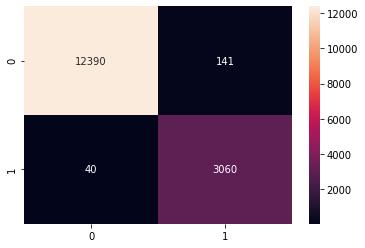

In [71]:
# # evaluate the model
# loss, acc = model.evaluate(X_test, y_test, verbose=0)
# print('Test Accuracy: %.3f' % acc)

# training metrics
scores = mlp_model.evaluate(seq_array.reshape(15631, 900), label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = mlp_model.predict(seq_array.reshape(15631, 900)) 
y_true = label_array

# Transform Y_pred to Binary Label
y_pred = np.where(y_pred > 0.5, 1, 0)


cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d')

In [72]:
# Calculate Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print( 'accuracy = ', accuracy,'\n', 'precision= ',precision,'\n', 'recall= ', recall,'\n','F1-score=', f1)

accuracy =  0.9884204465485253 
 precision=  0.9559512652296157 
 recall=  0.9870967741935484 
 F1-score= 0.9712744008887478


In [73]:
results_df = pd.DataFrame([[accuracy,precision,recall,f1]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['MLP'])
results_df

,Accuracy,Precision,Recall,F1-score
MLP,0.98842,0.955951,0.987097,0.971274


In [74]:
seq_array_test_last = [test_1[test_1['unit_number']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_1['unit_number'].unique() if len(test_1[test_1['unit_number']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 18)

In [75]:
y_mask = [len(test_1[test_1['unit_number']==id]) >= sequence_length for id in test_1['unit_number'].unique()]

In [76]:
label_array_test_last = test_1.groupby('unit_number')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [77]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 18)
(93, 1)


In [79]:
# test metrics
scores_test = mlp_model.evaluate(seq_array_test_last.reshape(93, 900), label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.0470 - accuracy: 0.9892
Accurracy: 0.9892473220825195


Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


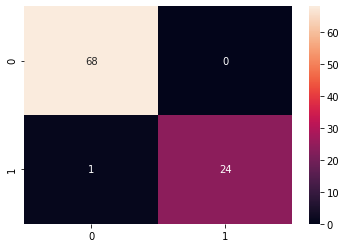

In [82]:
# make predictions and compute confusion matrix
y_pred_test = mlp_model.predict_classes(seq_array_test_last.reshape(93, 900))
y_true_test = label_array_test_last
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d')

In [83]:
# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

Precision:  1.0 
 Recall:  0.96 
 F1-score: 0.9795918367346939


In [87]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['MLP'])
results_df

,Accuracy,Precision,Recall,F1-score
MLP,0.989247,1.0,0.96,0.979592


XGBoost

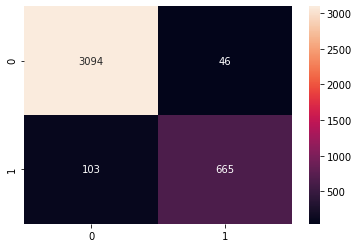

In [39]:
## Use XGBoost 
import xgboost as xgb
import matplotlib.pyplot as plt  
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

# Initialize Model
xgb_model = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 16, alpha = 10, n_estimators = 16)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(seq_array.reshape((15631, 900)), label_array, test_size=0.25, random_state=1337)

# Model Fitting on Data
xgb_model.fit(X_train, y_train)

# Get Predictions
y_pred = xgb_model.predict(X_test)

# Check Confusion Matrix
cm = confusion_matrix(y_test, y_pred)


sns.heatmap(cm, annot=True, fmt='d')

In [51]:
# Calculate Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print( 'accuracy = ', accuracy,'\n', 'precision= ',precision,'\n', 'recall= ', recall,'\n','F1-score=', f1)

accuracy =  0.9618730808597749 
 precision=  0.9353023909985936 
 recall=  0.8658854166666666 
 F1-score= 0.8992562542258283


In [52]:
results_df = pd.DataFrame([[accuracy,precision,recall,f1]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['XGboost'])
results_df

,Accuracy,Precision,Recall,F1-score
XGboost,0.961873,0.935302,0.865885,0.899256


In [150]:
# make predictions and compute confusion matrix
y_pred = model.predict(seq_array)
y_true = label_array

print(len(y_pred)) 
print(len(y_true))

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
# cm = confusion_matrix(y_true, y_pred)
# cm

15631
15631
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


CNN



In [54]:
# example of a cnn for image classification
from numpy import asarray
from numpy import unique
from numpy import argmax
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

In [64]:
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=2, save_best_only=True, mode='max', save_weights_only=False)
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(sequence_length, nb_features)))
cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(units=nb_out, activation='softmax'))

print(cnn_model.summary())

ValueError: ignored

In [59]:
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [61]:
cnn_model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.2, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15, verbose=1, mode='auto')])

Epoch 1/10


ValueError: ignored

In [ ]:
cnn_model.fit(x_train_img, y_train, batch_size=200, epochs=10, callbacks=[checkpoint], validation_split=0.2, verbose=1)